[View in Colaboratory](https://colab.research.google.com/github/redcican/Generatvie-Adversarial-Networks-/blob/master/03_DCGAN_(Deep_Convolutional_GANs).ipynb)

This notebook demonstrates how to generate imges of fashion-mnist using tf.keras and eager.executioin. To do so, we use Deep Convolutional Generative Adverserial Networks.

In [0]:
 !pip install imageio

    100% |████████████████████████████████| 3.3MB 4.2MB/s 


### 1. Import Tensorflow and enable eager execution

In [0]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display

### 2. Load the data

In [0]:
(train_images,train_labels),(_,_) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

train_images = (train_images - 127.5)/127.5

print("training image shape : {}".format(train_images.shape))

training image shape : (60000, 28, 28, 1)


In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

### 3. Use tf.data to create batches and shuffle the dataset

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(train_dataset)

<BatchDataset shapes: (?, 28, 28, 1), types: tf.float32>


### 4. Write the generator and discriminator models

* **Generator**

    * It is responsible for creating convincing images that are good enough to fool the discriminator
    * It consists of Conv2DTranspose (Upsampling) layers. We start with a fully conncected layer and upsample the image 2 times so as to reach the desired image size which is (28, 28, 1)
    * We use leaky relu activation except for the last layer which uses tanh activaiton
    
* ** Discriminator**
    * The discriminator is responsible for classifying the fake images from the real images.
    * In other words, the discriminator is given generated image (from the generator) and the real MNIST images. The job of the discriminator is to classify these images into fake (generated) and real (MNIST images)
    





In [0]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc1 = tf.keras.layers.Dense(7*7*64, use_bias=False)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        
        self.conv1 = tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(1,1), padding='same',use_bias=False)
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding='same',use_bias=False)
        self.batchnorm3 = tf.keras.layers.BatchNormalization()
        
        
        self.conv3 = tf.keras.layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same',use_bias=False)
        
        
    def call(self, x, training = True):
        x = self.fc1(x)
        x = self.batchnorm1(x, training=training)
        x = tf.nn.relu(x)
        
        x = tf.reshape(x, shape=(-1, 7, 7, 64))
        
        x = self.conv1(x)
        x = self.batchnorm2(x, training=training)
        x = tf.nn.relu(x)
        
        x = self.conv2(x)
        x = self.batchnorm3(x, training=training)
        x = tf.nn.relu(x)
        
        x = tf.nn.tanh(self.conv3(x))
        
        return x

In [0]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding='same')
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1)
        
    def call(self, x, training=True):
        x = tf.nn.leaky_relu(self.conv1(x))
        x = self.dropout(x, training=training)
        x = tf.nn.leaky_relu(self.conv2(x))
        x = self.dropout(x, training=training)
        x = self.flatten(x)
        x = self.fc1(x)
        
        return x

In [0]:
generator = Generator()
discriminator = Discriminator()

In [0]:
generator.call = tf.contrib.eager.defun(generator.call)
discriminator.call = tf.contrib.eager.defun(discriminator.call)

### 5. Define the loss functions and the optimizer

* **Discriminator loss**
    * The discriminator loss function takes 2 inputs: real images, generated images
    * real_loss is a sigmoid cross entropy loss of the real images and an array of ones (since these are the real images)
    * generated_loss is a sigmoid cross entropy loss of the generated images and array of zeros (since these are the fake images)
    * Then the total_loss is the sum of real_loss and the generated_loss
    
    
* **Generator loss**
    * It is a sigmoid cross entropy loss the generated images and array of ones
    
* The discriminator and the generator optimizers are different since we will train them separately


In [0]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...1] with real output since it is true and we want
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)
    
    # [0,0,...0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output),logits=generated_output)
    
    total_loss = real_loss + generated_loss
    
    return total_loss

In [0]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output),generated_output)

In [0]:
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
generator_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

### 6. Checkpoints

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

### 7. Training

* We start by iterating over the dataset
* The generator is given noise as input which when passed through the generator model will output a image looking
like a fashion image

* The discriminator is given the real Fashion MNIST images as well as the generated images

*  Next, we calculate the generator and the discriminator loss.

* Then, we calculate the gradients of loss with respect to both the generator and the discriminator
variables and apply those to the optimizer


### Generate images

* After training, it is time to generate some images!

* We start by creating noise array as an input to the generator

* The generator will then convert the noise into fashion images

* Last step is to plot the predictions and voila!

In [0]:
EPOCHS = 150
noise_dim = 100
num_example_to_generate = 16

random_vector_for_generation = tf.random_normal([num_example_to_generate,
                                                noise_dim])

In [0]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [0]:
def train(dataset, epochs, noise_dim):  
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      # generating noise from a uniform distribution
      noise = tf.random_normal([BATCH_SIZE, noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

      
    if epoch % 1 == 0:
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation)
    
    # saving (checkpoint) the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
  # generating after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)

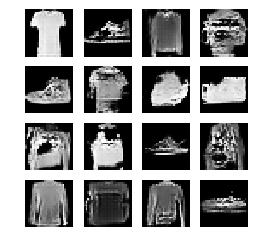

In [0]:
train(train_dataset, EPOCHS, noise_dim)

In [0]:
!ls

datalab			 image_at_epoch_0051.png  image_at_epoch_0102.png
image_at_epoch_0001.png  image_at_epoch_0052.png  image_at_epoch_0103.png
image_at_epoch_0002.png  image_at_epoch_0053.png  image_at_epoch_0104.png
image_at_epoch_0003.png  image_at_epoch_0054.png  image_at_epoch_0105.png
image_at_epoch_0004.png  image_at_epoch_0055.png  image_at_epoch_0106.png
image_at_epoch_0005.png  image_at_epoch_0056.png  image_at_epoch_0107.png
image_at_epoch_0006.png  image_at_epoch_0057.png  image_at_epoch_0108.png
image_at_epoch_0007.png  image_at_epoch_0058.png  image_at_epoch_0109.png
image_at_epoch_0008.png  image_at_epoch_0059.png  image_at_epoch_0110.png
image_at_epoch_0009.png  image_at_epoch_0060.png  image_at_epoch_0111.png
image_at_epoch_0010.png  image_at_epoch_0061.png  image_at_epoch_0112.png
image_at_epoch_0011.png  image_at_epoch_0062.png  image_at_epoch_0113.png
image_at_epoch_0012.png  image_at_epoch_0063.png  image_at_epoch_0114.png
image_at_epoch_0013.png  image_at_epoch_0064.png  im

### 8. Restore the latest checkpoint

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### 9. Display an image using the epoch number

In [0]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

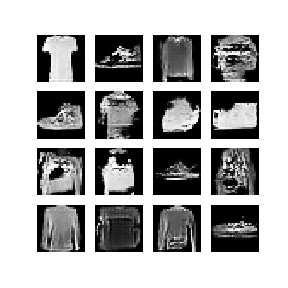

In [0]:
display_image(EPOCHS)

### 10. Generate a GIF of all the saved images

In [0]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
os.system('cp dcgan.gif dcgan.gif.png')

0

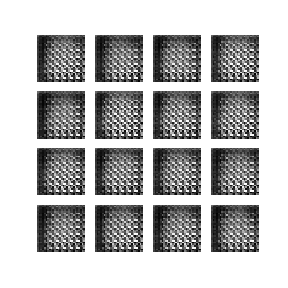

In [0]:
display.Image(filename="dcgan.gif.png")

In [0]:
from google.colab import files
files.download('dcgan.gif')